# Install dependencies

In [283]:
%pip install torch datasets nltk matplotlib

Note: you may need to restart the kernel to use updated packages.


In [284]:
import os
import nltk
nltk.download("all")

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/harry.tran/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is alread

# Part 0. Dataset Preparation

In [285]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [287]:
print(f"Size of training set: {train_dataset.num_rows} sentences")
print(f"Size of validation set: {validation_dataset.num_rows} sentences")
print(f"Size of test set: {test_dataset.num_rows} sentences")

Size of training set: 8530 sentences
Size of validation set: 1066 sentences
Size of test set: 1066 sentences


In [288]:
print(f"Sample sentence from train dataset: {test_dataset[0]['text']}")
print(f"Label: {'Positive' if test_dataset[0]['label'] == 1 else 'Negative'}")

Sample sentence from train dataset: lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .
Label: Positive


# Part 1. Preparing Word Embeddings

## Question 1. Word Embedding

#### `(a)` What is the size of the vocabulary formed from your training data?

In [289]:
def tokenize(text):
    return word_tokenize(text.lower())

In [290]:
word_counter = Counter()
for sample in train_dataset:
    word_counter.update(tokenize(sample['text']))

vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counter.items())}
vocab_size = len(vocab) + 2

print(f"Size of the vocabulary including PADDING and UNKNOWN tokens: {vocab_size}")
print(f"Size of the vocabulary: {vocab_size - 2}")

Size of the vocabulary including PADDING and UNKNOWN tokens: 18031
Size of the vocabulary: 18029


`<PAD>` token was introduced for easier processing at later steps. Because RNN requires all sentences having the same length

`<UNK>` token was introduced for handling unknown word in `Word2vec` vocabulary. All unkown words will be assigned as a `<UNK>` token

By using punkt tokenizer from NLTK, size of the vocabulary formed from training data is `18029`

#### `(b)` We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

#### `(c)` The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.

In [291]:
glove_path = f"{os.getcwd()}/glove/glove.6B.300d.txt"
if not os.path.isfile(glove_path):
    raise FileNotFoundError(f"GloVe file does not exist. Please install GloVe here https://nlp.stanford.edu/data/glove.6B.zip and place in {glove_path}")

def load_glove_embeddings():
    embedding_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict

glove_embeddings = load_glove_embeddings()


In [292]:
embedding_dim = len(next(iter(glove_embeddings.values())))
known_embeddings = np.array(list(glove_embeddings.values()))
embedding_mean = np.mean(known_embeddings, axis=0)
embedding_std = np.std(known_embeddings, axis=0)
print(f"Embedding dimensions: {embedding_dim}")

Embedding dimensions: 300


In [293]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_words = []

# Fill the embedding matrix
for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        oov_words.append(word)
        # Sample from normal distribution with same mean and std as known embeddings
        embedding_matrix[idx] = np.random.normal(embedding_mean, embedding_std, embedding_dim)

print(f"Number of OOV words: {len(oov_words)}")

Number of OOV words: 1865


`(b)` There are 1865 out-of-vocabulary words in our data

`(c)` To address out-of-vocabulary (OOV) words in GloVe, we assigned them embeddings generated from random samples of a normal distribution based on the mean and standard deviation of all existing word vectors. This approach offers several advantages:

- Consistency in Input: Randomly generated embeddings ensure a consistent shape and dimensionality for OOV words, facilitating seamless integration into the model.
- Statistical Alignment: By matching the mean and standard deviation of known embeddings, we align the OOV representations with the learned vocabulary, reducing the potential instability introduced by random noise.

# Part 2. Model Training & Evaluation - RNN

In [294]:
# Tokenizing the dataset and ensuring valid index range
def tokenize_sentence(sentence, vocab):
    tokens = tokenize(sentence)
    return [vocab.get(token, 1) for token in tokens]  # Replace OOV words with index 1 (UNK)

# Define the Sentiment Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.sentences = [tokenize_sentence(sample['text'], vocab) for sample in dataset]
        self.labels = [sample['label'] for sample in dataset]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]), torch.tensor(self.labels[idx])

In [295]:
class AveragePollingRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(AveragePollingRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)  # Dropout layer to reduce overfitting (can be increased)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_rnn_out, _ = self.rnn(packed_embedded)
        rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

        # Apply average pooling across the sequence length dimension
        batch_size, max_len, hidden_dim = rnn_out.size()
        mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
        rnn_out = rnn_out * mask.unsqueeze(2)  # Mask out padding tokens
        sentence_representation = rnn_out.sum(dim=1) / lengths.unsqueeze(1).float()

        sentence_representation = self.batch_norm(sentence_representation)
        sentence_representation = self.dropout(sentence_representation)
        output = self.fc(sentence_representation)
        return output
    


class MaxPollingRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(MaxPollingRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)  # Dropout layer to reduce overfitting
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
        # Pack the sequences to handle varying sentence lengths
        packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_rnn_out, _ = self.rnn(packed_embedded)
        rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

        # Apply max pooling across the sequence length dimension
        batch_size, max_len, hidden_dim = rnn_out.size()
        
        # Apply mask to ignore padding tokens in the max pooling operation
        mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
        rnn_out[~mask] = float('-inf')  # Set padding positions to negative infinity before max pooling
        
        # Max pooling across the time dimension
        sentence_representation, _ = torch.max(rnn_out, dim=1)  # Max pooling along the time axis
        
        # Apply batch normalization and dropout
        sentence_representation = self.batch_norm(sentence_representation)
        sentence_representation = self.dropout(sentence_representation)

        # Pass through fully connected layer for classification
        output = self.fc(sentence_representation)
        return output

In [296]:
train_data = SentimentDataset(train_dataset, vocab)
val_data = SentimentDataset(validation_dataset, vocab)
test_data = SentimentDataset(test_dataset, vocab)

# Padding function for data loader
def collate_fn(batch):
    sentences, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences])
    sentences_padded = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return sentences_padded, labels, lengths

In [297]:
def train_epoch(model, data_loader, criterion, optimizer):
    total_train_loss = 0.0
    total_correct_train = 0
    total = 0

    for sentences, labels, lengths in data_loader:
        optimizer.zero_grad()

        output = model(sentences, lengths)

        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1
        )  # Apply gradient clipping to prevent exploding gradients
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total_correct_train += (predicted == labels).sum().item()
        total += labels.size(0)
    train_loss = total_train_loss / len(data_loader)
    train_accuary = total_correct_train / total

    return train_loss, train_accuary


def evaluate_epoch(model, data_loader, criterion):
    model.eval()

    total_val_loss = 0.0
    total_correct_val = 0
    total_val = 0

    with torch.no_grad():
        for sentences, labels, lengths in data_loader:
            output = model(sentences, lengths)
            loss = criterion(output, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(output, 1)

            total_val += labels.size(0)
            total_correct_val += (predicted == labels).sum().item()

    val_loss = total_val_loss / len(data_loader)
    val_acc = total_correct_val / total_val

    return val_loss, val_acc

def draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, title):
    num_epochs = len(train_losses)  # Number of epochs
    # Plotting train and validation loss
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Adjust layout to avoid overlapping
    plt.tight_layout()

    # Display the plots
    plt.show()

## Experiment 1:  Same hyperparameters, different embeddings

/Users/harry.tran/Downloads/Code/SC4002_Project/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/var/folders/0f/9lfqv2_d3dd8rwwcwl7x4r000000gr/T/ipykernel_59369/2195780392.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentences_padded = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True, padding_value=0)


Epoch [1/50]
Train Loss: 0.5808, Train Acc: 0.7041 , Val Loss: 0.5389, Val Acc: 0.7233
Epoch [2/50]
Train Loss: 0.5198, Train Acc: 0.7379 , Val Loss: 0.5402, Val Acc: 0.7317
Epoch [3/50]
Train Loss: 0.5072, Train Acc: 0.7469 , Val Loss: 0.5526, Val Acc: 0.7195
Epoch [4/50]
Train Loss: 0.5010, Train Acc: 0.7522 , Val Loss: 0.5095, Val Acc: 0.7570
Epoch [5/50]
Train Loss: 0.4794, Train Acc: 0.7639 , Val Loss: 0.5006, Val Acc: 0.7542
Epoch [6/50]
Train Loss: 0.4788, Train Acc: 0.7639 , Val Loss: 0.5289, Val Acc: 0.7505
Epoch [7/50]
Train Loss: 0.4620, Train Acc: 0.7770 , Val Loss: 0.4971, Val Acc: 0.7655
Epoch [8/50]
Train Loss: 0.4559, Train Acc: 0.7787 , Val Loss: 0.5301, Val Acc: 0.7617
Epoch [9/50]
Train Loss: 0.4466, Train Acc: 0.7852 , Val Loss: 0.5687, Val Acc: 0.7214
Epoch [10/50]
Train Loss: 0.4184, Train Acc: 0.8016 , Val Loss: 0.4991, Val Acc: 0.7730
Early stopping as validation accuracy is not improving


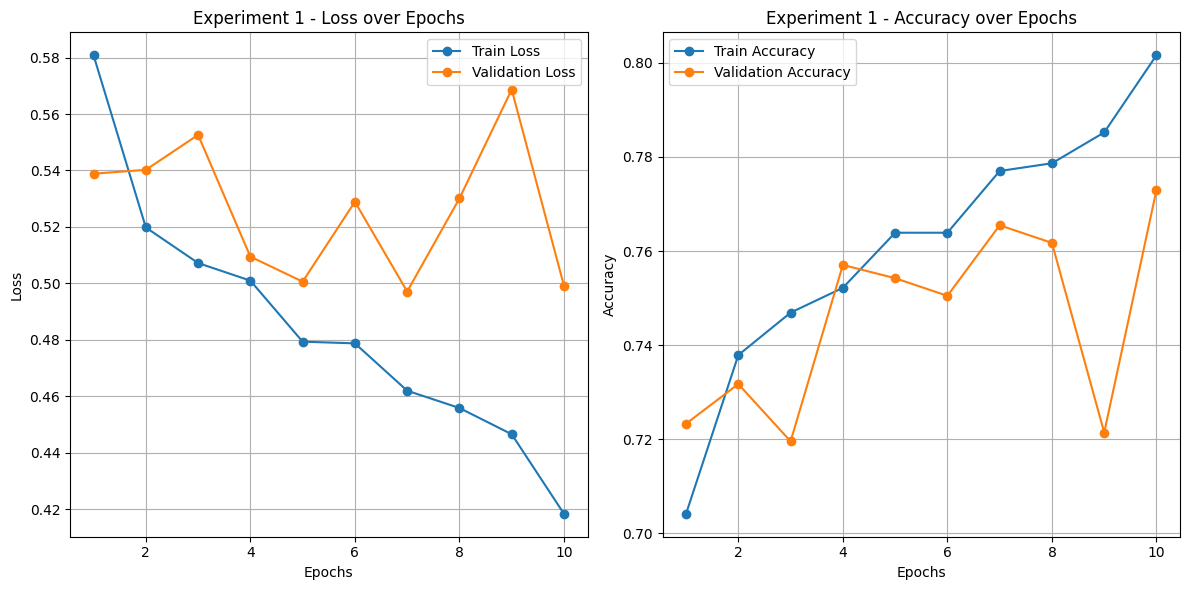

In [298]:
batch_size = 32
hidden_dim = 256
output_dim = 2 
epochs = 50
learning_rate = 0.0005
weight_decay=1e-5

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = AveragePollingRNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
model.to(device)

# Training the model with early stopping
num_epochs = 50
patience = 3 
best_val_loss = float("inf")
early_stopping_count = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_loss, val_acc = evaluate_epoch(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} , Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping if validation accuracy does not improve for 3 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pth')
        early_stopping_count = 0
    else:
        early_stopping_count += 1
        if early_stopping_count >= patience:
            print("Early stopping as validation accuracy is not improving")
            break

draw_plot(train_losses, train_accuracies, val_losses, val_accuracies, "Experiment 1")


In [299]:
# Evaluate on test set
model.load_state_dict(torch.load('best_rnn_model.pth'))
model.to(device)

test_loss, test_acc = evaluate_epoch(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

/var/folders/0f/9lfqv2_d3dd8rwwcwl7x4r000000gr/T/ipykernel_59369/3962143332.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_rnn_mo

Test Loss: 0.4956, Test Acc: 0.7439


In [300]:
# # AVERAGE POOLING
# class AverageRNNModel(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
#         super(AverageRNNModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
#         self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float))
#         self.embedding.weight.requires_grad = False  # Freeze embeddings

#         self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
#         self.dropout = nn.Dropout(0.5)  # Dropout layer to reduce overfitting (can be increased)
#         self.batch_norm = nn.BatchNorm1d(hidden_dim)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x, lengths):
#         embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
#         packed_embedded = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
#         packed_rnn_out, _ = self.rnn(packed_embedded)
#         rnn_out, _ = pad_packed_sequence(packed_rnn_out, batch_first=True)

#         # Apply average pooling across the sequence length dimension
#         batch_size, max_len, hidden_dim = rnn_out.size()
#         mask = torch.arange(max_len).expand(batch_size, max_len) < lengths.unsqueeze(1)
#         rnn_out = rnn_out * mask.unsqueeze(2)  # Mask out padding tokens
#         sentence_representation = rnn_out.sum(dim=1) / lengths.unsqueeze(1).float()

#         sentence_representation = self.batch_norm(sentence_representation)
#         sentence_representation = self.dropout(sentence_representation)
#         output = self.fc(sentence_representation)
#         return output
    

# # MAX POOLING

# # Model parameters


# # Initialize the learning rate scheduler to reduce learning rate when validation loss plateaus

# # Initialize the best validation loss and other parameters for early stopping
# best_val_loss = float('inf')
# patience = 5  # Stop training if validation loss does not improve for 5 consecutive epochs
# epochs_no_improve = 0
# early_stop = False  # Flag to control early stopping

# # List to store validation losses for plotting
# val_losses = []

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0

#     for sentences, labels, lengths in train_loader:
#         optimizer.zero_grad()
#         output = model(sentences, lengths)
#         loss = criterion(output, labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Apply gradient clipping to prevent exploding gradients
#         optimizer.step()

#         train_loss += loss.item()
#         _, predicted = torch.max(output, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     train_acc = correct / total

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     correct_val = 0
#     total_val = 0
#     with torch.no_grad():
#         for sentences, labels, lengths in val_loader:
#             output = model(sentences, lengths)
#             loss = criterion(output, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(output, 1)
#             total_val += labels.size(0)
#             correct_val += (predicted == labels).sum().item()

#     val_loss = val_loss / len(val_loader)
#     val_acc = correct_val / total_val

#     # Store validation loss for plotting
#     val_losses.append(val_loss)

#     # Scheduler step: Reduces learning rate when validation loss plateaus for 3 epochs
#     scheduler.step(val_loss)

#     # Check for early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0  # Reset the patience counter
#     else:
#         epochs_no_improve += 1

#     if epochs_no_improve >= patience:
#         print(f"Early stopping at epoch {epoch+1}")
#         early_stop = True
#         break

#     # Output training and validation results
#     print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

#     if early_stop:
#         break

# # Plot validation losses
# plt.figure(figsize=(10,6))
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Validation Loss')
# plt.title('Validation Loss over Epochs with Early Stopping')
# plt.legend()
# plt.grid(True)
# plt.show()
